In [14]:
# NN libraries
import torch
import torch.nn as nn

# Libraries for solving PDE numerically and plotting
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import diags
from scipy.sparse.linalg import factorized

In [15]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

def sin(x):
    if isinstance(x, torch.Tensor): 
        return torch.sin(x)
    else:
        return np.sin(x)

def exp(x):
    if isinstance(x, torch.Tensor): 
        return torch.exp(x)
    else:
        return np.exp(x)

from pathlib import Path
# Create used directories
directories = ["gifs", "PINN_Plots"]
for d in directories:
    plots_dir = Path(d)
    plots_dir.mkdir(exist_ok=True)
    print(f"Directory '{plots_dir}' is present. ✅")


Directory 'gifs' is present. ✅
Directory 'PINN_Plots' is present. ✅


In [43]:
# Define PDE Parameters
xi, xf, dx = 0, 1, 1e-2
ti, tf, dt = 0, 1, 1e-3

a = 1e-1

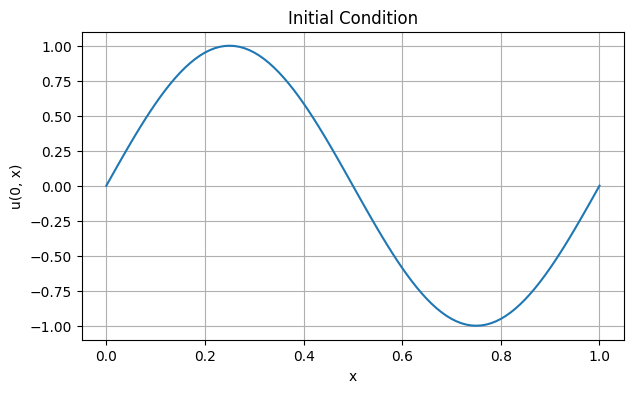

In [44]:
# Initial conditions

x = np.arange(xi, xf + dx, dx, dtype=np.float32)
t = np.arange(ti, tf + dt, dt, dtype=np.float32)
Nx, Nt = len(x), len(t)

def u0(x):
    return sin(2*np.pi*x)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x, u0(x))
ax.set_xlabel('x')
ax.set_ylabel('u(0, x)')
ax.set_title('Initial Condition')
ax.grid()
plt.show()

In [45]:
# Create matricies for solving PDE
u = np.zeros((Nt, Nx))

def D2_t():
    d = 1/(dx**2 * 12)
    D = d * diags([-1, 16, -30, 16, -1], [-2, -1, 0, 1, 2], shape=(Nx, Nx)).toarray()
    D[0, [-2, -1]] = [-d, 16*d]
    D[1, [-1]] = [-d]
    D[-1, [0, 1]] = [16*d, -d]
    D[-2, [0, 1]] = [-d]
    return sparse.csr_matrix(D)

u = np.zeros((Nt, Nx))
I = diags([1], [0], shape=(Nx, Nx))
A = (I - dt*a/2 * D2_t())
B = (I + dt*a/2 * D2_t())
solve_A = factorized(A.tocsc())

t = 0.000s, u_max = 1.000
t = 0.100s, u_max = 0.677
t = 0.200s, u_max = 0.464
t = 0.300s, u_max = 0.319
t = 0.400s, u_max = 0.221
t = 0.500s, u_max = 0.153
t = 0.600s, u_max = 0.107
t = 0.700s, u_max = 0.076
t = 0.800s, u_max = 0.054
t = 0.900s, u_max = 0.039
t = 1.000s, u_max = 0.029


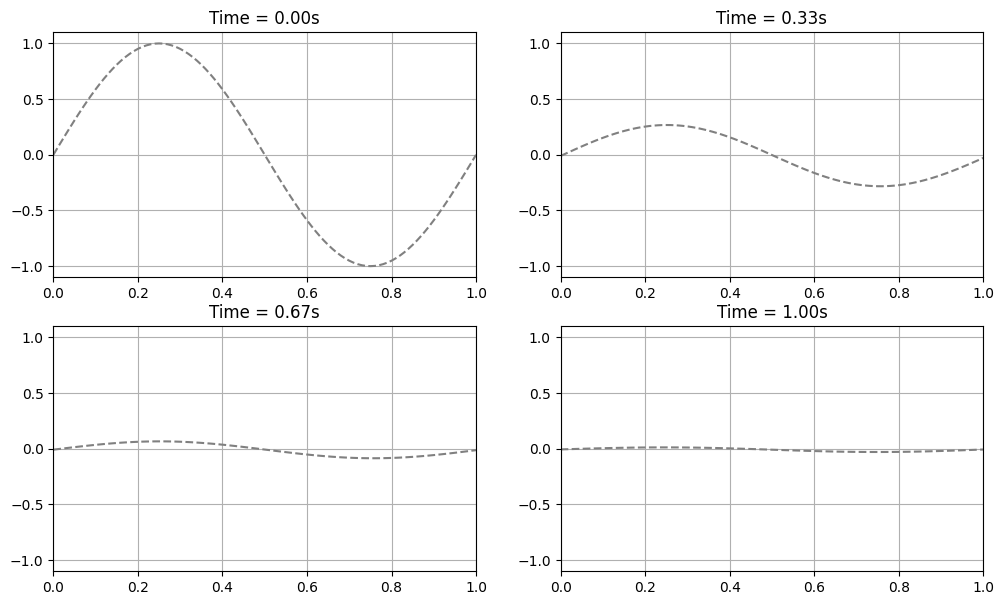

In [46]:
# Numerically Solve PDE wth Crank-Nicolson method

for j, tj in enumerate(t):
    if j == 0:
        u[0, :] = u0(x)
    else:
        uj = u[j-1, :]
        u[j, :] = solve_A(B @ uj)
    if j % int(1/dt * 1e-1) == 0: # Every once in a while print some info on solving
        print(f"t = {tj:.3f}s, u_max = {np.max(np.abs(u[j, :])):.3f}")


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
titles = ['t = 0', 't=0.25', 't = 0.5', 't = 1']
time_indecies = torch.linspace(0, Nt-1, 4, dtype=int)
for j, ax in enumerate(axs.flat):
    tj = time_indecies[j]
    ax.plot(x, u[tj, :], c="gray", linestyle='--')
    ax.set_title(f"Time = {t[tj]:.2f}s")
    ax.grid()
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(xi, xf)

plt.show()

In [21]:
def training_plot(save=False, file_name=""):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
    titles = ['t = 0', 't=0.25', 't = 0.5', 't = 1']
    time_indecies = torch.linspace(0, Nt-1, 4, dtype=int)
    for j, ax in enumerate(axs.flat):
        tj = time_indecies[j]
        ax.plot(x, p[tj, :], c='blue')
        ax.plot(x, u[tj, :], c="gray", linestyle='--')
        ax.set_title(f"Time = {t[tj]:.2f}s")
        ax.grid()
        ax.set_ylim(-1.1, 1.1)
        ax.set_xlim(xi, xf)
        ax.scatter(boundary1_domain[0, 1], u[tj, 0], s=20, color="purple")
        ax.scatter(boundary2_domain[0, 1], u[tj, -1], s=20, color="purple", label="Boundary Condition")
        ax.scatter(x_col, torch.zeros_like(x_col), color="green", label="Colocation Points", s=5)
    
    axs[0, 0].scatter(initial_x, u0(initial_x), color="red", s=10, label="Initial Condition")
    axs[0, 1].scatter(x_data, u[time_indecies[1], x_indecies], color="black", s=10, label="Training Data")
    fig.suptitle(f"Epoch: {i}")
    axs[0,0].legend()
    axs[0,1].legend()
    
    if save:
        fig.savefig(file_name, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")

In [22]:
# Define PINN architecture

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        
        self.fcs   = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN),activation()])
        self.fch   = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce   = nn.Linear(N_HIDDEN, N_OUTPUT)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) 
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [50]:
# Define PINN Hyperparameters

learning_rate = 1e-3
epochs        = 20_000 + 1
weights = [w_initial, w_data, w_boundary, w_PDE] = [1e1, 0e1, 1e0, 1e0]

N_initial  = 50
N_boundary = 50
N_training_t = 20
N_training_x = 20
N_col      = 50

N_layers = 6
N_nodes  = 64

In [51]:
# Domain for initial condition
initial_x = torch.linspace(xi, xf, N_initial)
initial_t = torch.zeros(N_initial)
initial_domain = torch.stack((initial_t, initial_x), dim=1)
initial_u = u0(initial_x).view(-1,1)

# Domain for boundary condition
boundary1_domain = torch.stack((torch.linspace(ti, tf, N_boundary),  x[0]*torch.ones(N_boundary)), dim=1)
boundary2_domain = torch.stack((torch.linspace(ti, tf, N_boundary), x[-1]*torch.ones(N_boundary)), dim=1)

# Domain for training data
t_indecies = torch.linspace(1, (Nt-1)//3, N_training_t, dtype=int) # Defined in terms of indecies to make getting u and corresponding (t,x) values easier
x_indecies = torch.linspace(1, Nx-1, N_training_x, dtype=int)
Ti_mat, Xi_mat = torch.meshgrid(t_indecies, x_indecies, indexing='ij')

t_data = (torch.from_numpy(t))[t_indecies]
x_data = (torch.from_numpy(x))[x_indecies]
Td, Xd = torch.meshgrid(t_data, x_data, indexing='ij')
training_domain = torch.stack((Td.flatten(), Xd.flatten()), dim=1) # (t, x) values that correspond to the u values used for training
training_u      = torch.from_numpy(u)[Ti_mat, Xi_mat].view(-1,1)   # Values of u used in training

# Domain for collocation points
t_col  = torch.linspace(ti, tf, N_col)
x_col  = torch.linspace(xi, xf, N_col)
Tc, Xc = torch.meshgrid(t_col, x_col, indexing='ij')
colocation_domain = torch.stack((Tc.flatten(), Xc.flatten()), dim=1).requires_grad_(True)

# Domain for Error calculation
T, X = torch.meshgrid(torch.from_numpy(t), torch.from_numpy(x), indexing='ij')
input_Domain = torch.stack((T.flatten(), X.flatten()), dim=1)

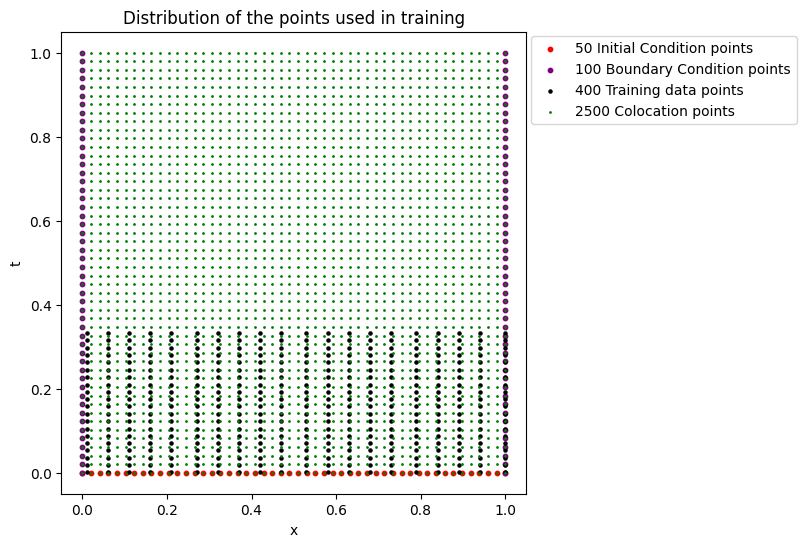

In [52]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(initial_x, initial_t, s=10, color="Red", label=f"{N_initial} Initial Condition points")
ax.scatter(boundary1_domain[:,1], boundary1_domain[:,0], s=10, color="purple")
ax.scatter(boundary2_domain[:,1], boundary2_domain[:,0], s=10, color="purple", label=f"{2*N_boundary} Boundary Condition points")
ax.scatter(training_domain[:,1], training_domain[:,0], s= 5, color="black", label=f"{len(training_domain)} Training data points")
ax.scatter(colocation_domain.detach()[:,1], colocation_domain.detach()[:,0], s=1, color="green", label=f"{N_col**2} Colocation points", zorder=1)
ax.legend(loc=(1.01, 0.8))
ax.set_ylabel("t")
ax.set_xlabel("x")
ax.set_title("Distribution of the points used in training")
plt.show()

Epoch: 0, Loss: 4.6313e+00, MSE = 5.3674e-02, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00


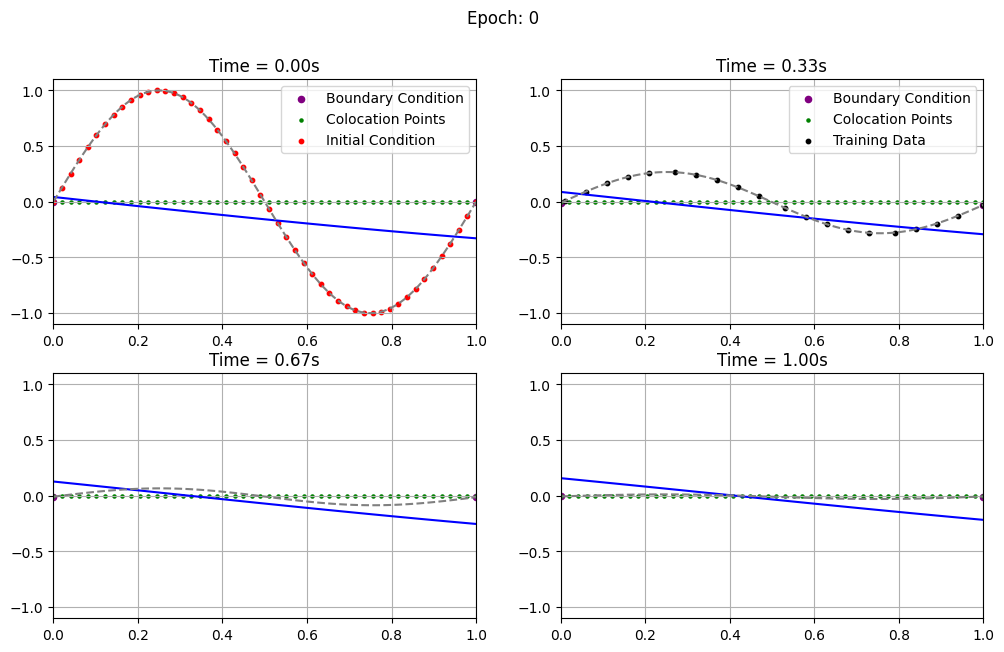

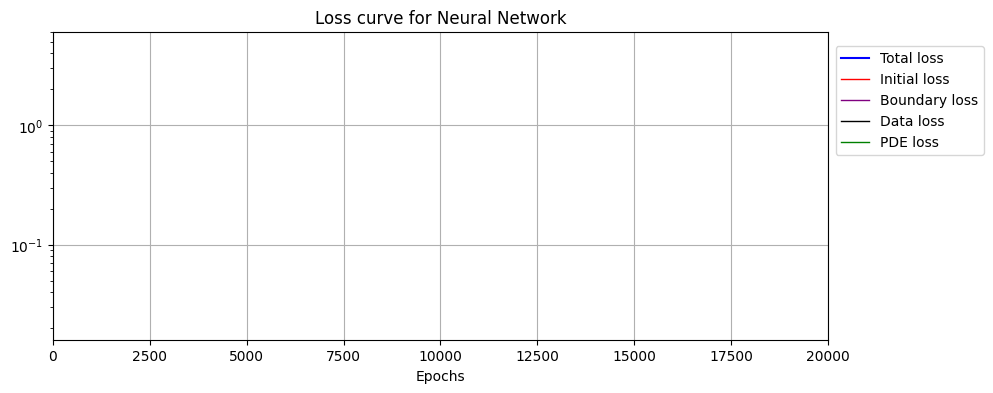

Epoch: 100, Loss: 2.0467e-01, MSE = 2.6439e-03, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 200, Loss: 2.4617e-02, MSE = 7.0452e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 300, Loss: 1.1231e-02, MSE = 9.6536e-05, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 400, Loss: 5.5702e-03, MSE = 7.8081e-05, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 500, Loss: 3.1650e-03, MSE = 1.0906e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 600, Loss: 1.9928e-03, MSE = 1.2596e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 700, Loss: 1.3959e-03, MSE = 1.9003e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 800, Loss: 2.7525e-03, MSE = 6.9075e-05, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 900, Loss: 2.4980e-03, MSE = 1.2217e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 1000, Loss: 6.8814e-04, MSE = 1.5506e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00

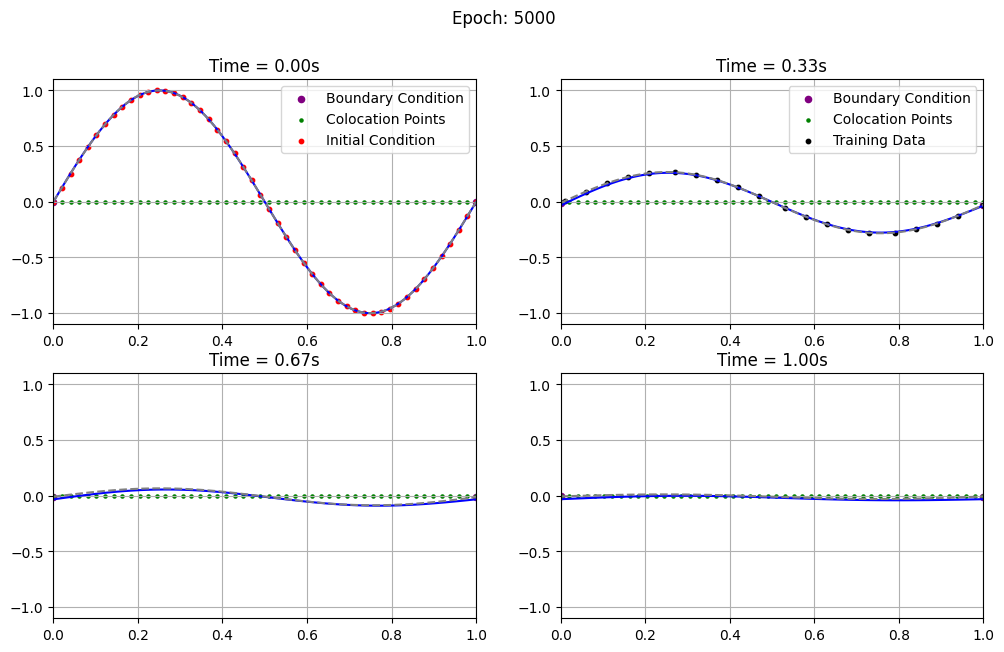

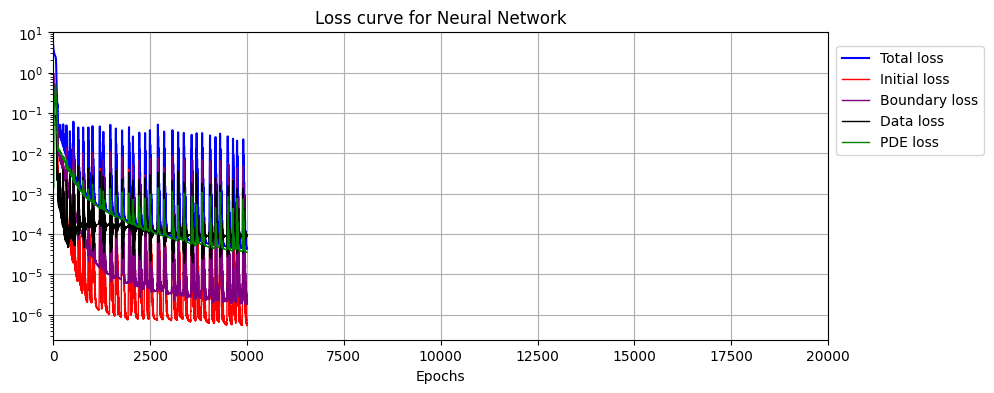

Epoch: 5100, Loss: 1.1378e-04, MSE = 9.7424e-05, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 5200, Loss: 6.5713e-05, MSE = 1.1906e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 5300, Loss: 5.2071e-05, MSE = 1.3719e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 5400, Loss: 1.0232e-04, MSE = 1.4425e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 5500, Loss: 1.0625e-04, MSE = 1.7255e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 5600, Loss: 3.9029e-05, MSE = 1.5232e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 5700, Loss: 2.2080e-04, MSE = 1.9153e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 5800, Loss: 5.8271e-03, MSE = 5.4848e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 5900, Loss: 9.6163e-04, MSE = 1.9322e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 6000, Loss: 3.5365e-05, MSE = 1.6847e-04, Learning rate = 1.0000e-03, PDE weight = 1

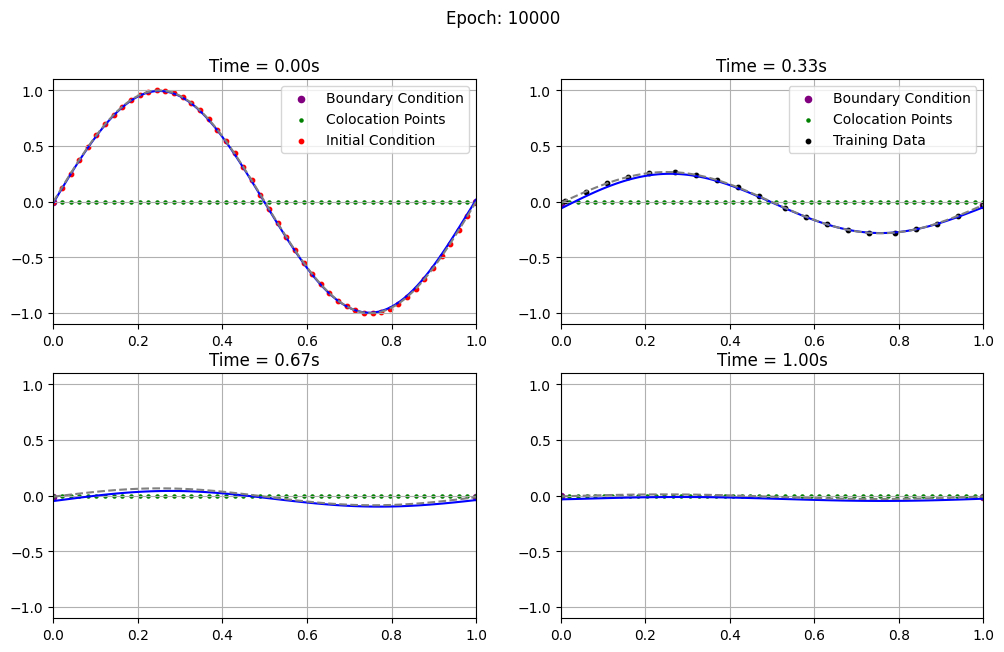

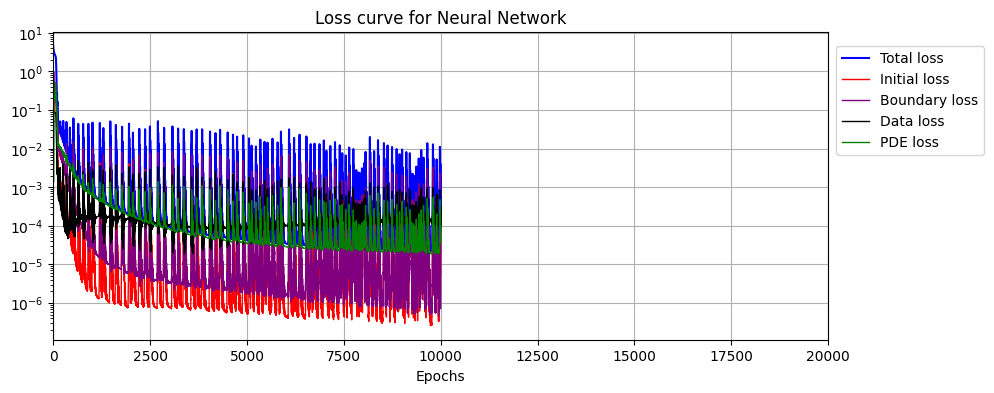

Epoch: 10100, Loss: 3.5117e-03, MSE = 4.0603e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 10200, Loss: 2.6359e-04, MSE = 2.7704e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 10300, Loss: 6.4657e-05, MSE = 2.4378e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 10400, Loss: 6.3738e-04, MSE = 2.5579e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 10500, Loss: 5.3530e-05, MSE = 2.4155e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 10600, Loss: 6.6822e-05, MSE = 2.4156e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 10700, Loss: 1.0771e-03, MSE = 5.5363e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 10800, Loss: 3.6553e-05, MSE = 2.1399e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 10900, Loss: 7.9082e-05, MSE = 2.5491e-04, Learning rate = 1.0000e-03, PDE weight = 1.0000e+00
Epoch: 11000, Loss: 6.2340e-04, MSE = 3.5758e-04, Learning rate = 1.0000e-03, PDE 

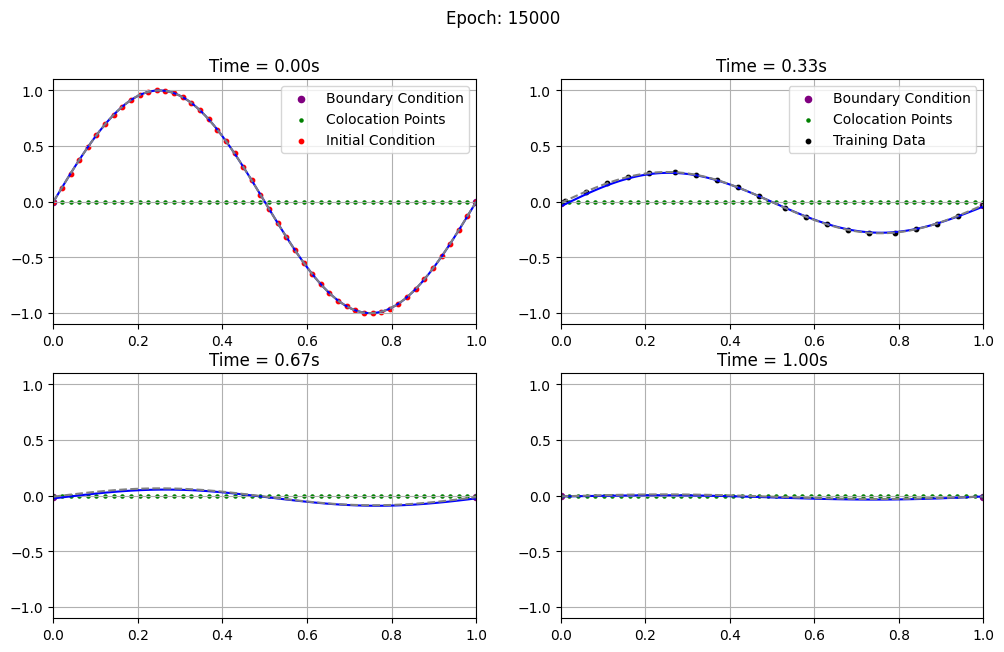

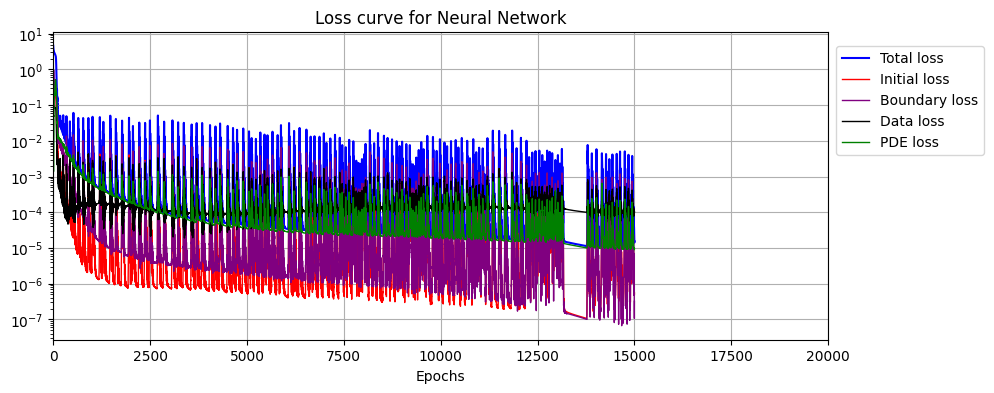

Epoch: 15100, Loss: 8.0408e-05, MSE = 1.3688e-04, Learning rate = 7.5000e-04, PDE weight = 1.0000e+00
Epoch: 15200, Loss: 7.9296e-04, MSE = 1.5518e-04, Learning rate = 7.5000e-04, PDE weight = 1.0000e+00
Epoch: 15300, Loss: 6.9029e-04, MSE = 7.2583e-05, Learning rate = 7.5000e-04, PDE weight = 1.0000e+00
Epoch: 15400, Loss: 1.2132e-05, MSE = 9.0112e-05, Learning rate = 7.5000e-04, PDE weight = 1.0000e+00
Epoch: 15500, Loss: 1.8722e-04, MSE = 1.3124e-04, Learning rate = 7.5000e-04, PDE weight = 1.0000e+00
Epoch: 15600, Loss: 4.5866e-03, MSE = 2.3778e-04, Learning rate = 7.5000e-04, PDE weight = 1.0000e+00
Epoch: 15700, Loss: 1.0205e-03, MSE = 1.7690e-04, Learning rate = 7.5000e-04, PDE weight = 1.0000e+00
Epoch: 15800, Loss: 2.9560e-04, MSE = 5.3384e-05, Learning rate = 7.5000e-04, PDE weight = 1.0000e+00
Epoch: 15900, Loss: 9.0620e-06, MSE = 7.8332e-05, Learning rate = 7.5000e-04, PDE weight = 1.0000e+00
Epoch: 16000, Loss: 3.4015e-04, MSE = 9.1253e-05, Learning rate = 7.5000e-04, PDE 

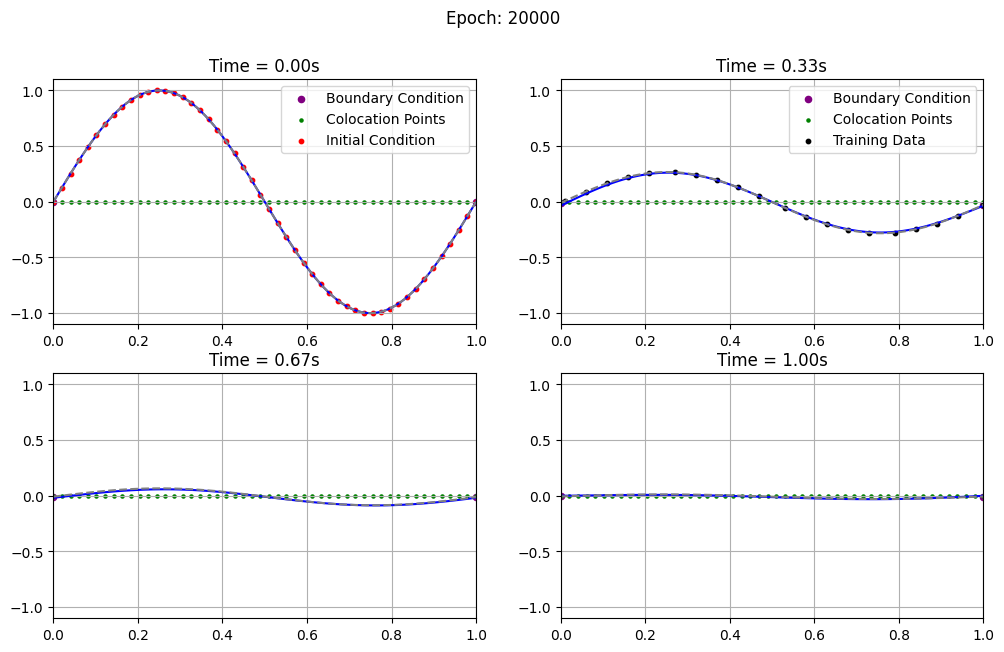

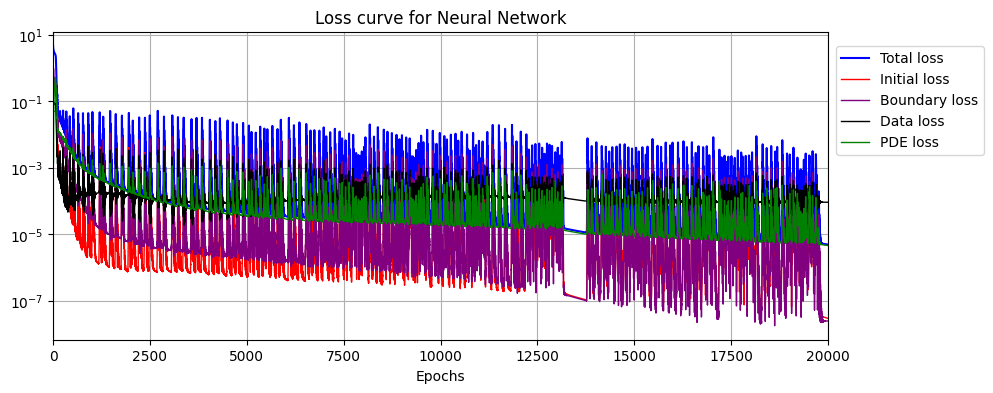

In [53]:
# Neural Network without physics

Diffusion_PINN = FCN(2, 1, N_nodes, N_layers) # 2 inputs and 1 output since u: RxR -> R, u: (t,x)|->u(t,x)
optimizer      = torch.optim.Adam(Diffusion_PINN.parameters(), lr=learning_rate) # Using the Adam optimizer
scheduler      = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=1000, min_lr=1e-6) 

mse_history  = []
loss_history = []
pde_loss_history  = []
data_loss_history = []
initial_loss_history = []
boundary_loss_history = []


for i in range(epochs):
    Diffusion_PINN.train()
    optimizer.zero_grad()
    
    # Initial Loss
    initial_p    = Diffusion_PINN(initial_domain)
    loss_initial = torch.mean((initial_p - initial_u)**2)
    
    # Boundary Loss
    boundary1_p = Diffusion_PINN(boundary1_domain)
    boundary2_p = Diffusion_PINN(boundary2_domain)
    loss_boundary = torch.mean((boundary1_p - boundary2_p)**2)
    
    # Data Loss
    s = Diffusion_PINN(training_domain)
    loss_data = torch.mean((s - training_u)**2)
    
    # Physics Loss
    v  = Diffusion_PINN(colocation_domain)
    Dv = torch.autograd.grad(v, colocation_domain, torch.ones_like(v), create_graph=True)[0]
    
    v_t  = Dv[:, 0:1]
    v_x  = Dv[:, 1:2]
    
    Dv_x = torch.autograd.grad(v_x, colocation_domain, torch.ones_like(v_x), create_graph=True)[0]
    v_xx = Dv_x[:, 1:2]
    
    loss_PDE = torch.mean((v_t - a*v_xx)**2)

    # Total Loss
    losses  = [loss_initial.item(), loss_data.item(), loss_boundary.item(), loss_PDE.item()]
    
    loss = weights[0]*loss_initial + weights[1]*loss_data + weights[2]*loss_boundary + weights[3]*loss_PDE
    
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    Diffusion_PINN.eval()
    
    # Finds the Mean Squared Error with the real solution
    P = Diffusion_PINN(input_Domain).detach()
    p = P.numpy().reshape(Nt, Nx)
    MSE = np.mean((u - p)**2)
    
    loss_history.append(loss.item())
    initial_loss_history.append(losses[0])
    data_loss_history.append(losses[1])
    boundary_loss_history.append(losses[2])
    pde_loss_history.append(losses[3])
    
    if i % 100 == 0:
        print(f"Epoch: {i}, Loss: {loss.item():.4e}, MSE = {MSE:.4e}, Learning rate = {optimizer.param_groups[0]['lr']:.4e}, PDE weight = {w_PDE:.4e}")
        if i % 5000 == 0:
            training_plot()
            plt.show()
            fig, ax = plt.subplots(figsize=(10, 4))
            lw = 1
            ax.set_title("Loss curve for Neural Network")
            ax.plot(loss_history, label="Total loss", c="blue")
            ax.plot(initial_loss_history, label="Initial loss", c="red", lw=lw)
            ax.plot(boundary_loss_history, label="Boundary loss", c="purple", lw=lw)
            ax.plot(data_loss_history, label="Data loss", c="black", lw=lw)
            ax.plot(pde_loss_history, label="PDE loss", c="green", lw=lw)
            ax.set_xlabel("Epochs")
            ax.set_yscale("log")
            ax.set_xlim(0, epochs)
            ax.legend(loc=(1.01, 0.6))
            ax.grid()
            plt.show()

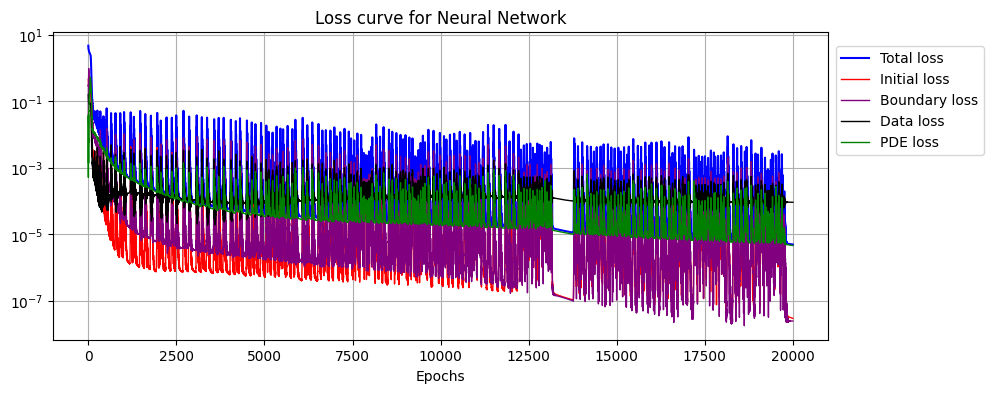

In [54]:
lw = 1
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Loss curve for Neural Network")
ax.plot(loss_history, label="Total loss", c="blue")
ax.plot(initial_loss_history, label="Initial loss", c="red", lw=lw)
ax.plot(boundary_loss_history, label="Boundary loss", c="purple", lw=lw)
ax.plot(data_loss_history, label="Data loss", c="black", lw=lw)
ax.plot(pde_loss_history, label="PDE loss", c="green", lw=lw)
ax.set_xlabel("Epochs")
ax.set_yscale("log")
ax.legend(loc=(1.01, 0.6))
ax.grid()
plt.show()

In [55]:
from PIL import Image

def save_gif_PIL(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=round(1000/fps), loop=loop)

def make_plot(save=False, file_name=f"PDE_solution.png", ti=0):
    fig, ax = plt.subplots()
    ax.plot(x, u[i, :], label='Numerical Solution Solution', linestyle='--', c="black")
    ax.plot(x, p[i, :], label='PINN Solution', c="blue")
    ax.set_xlim(xi, xf)
    ax.set_ylim(-1.05, 1.05)
    ax.grid()
    ax.set_title(f"Time = {ti:.3f}s")
    ax.legend()
    if save:
        fig.savefig(file_name, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")

In [56]:
import os
import shutil

folder_path="PINN_plots"
for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  # Remove file or symbolic link
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  # Remove subdirectory and its contents
    except Exception as e:
        print(f"Failed to delete {item_path}. Reason: {e}")

In [57]:
files = []
fps   = 20
frame_indicies = np.linspace(0, Nt-1, 4*int(fps*t[-1]), dtype=int)
N_frames = len(frame_indicies)
for i, index in enumerate(frame_indicies):
    tj = t[index]
    file = f"PINN_plots/PDE_sol_{tj:.5f}.png"
    make_plot(save=True, file_name=file, ti=tj)
    files.append(file)
    plt.close("all")
    print(f"{i}/{N_frames}")
    
save_gif_PIL("gifs/Diffusion_PINN_Comparison.gif", files, fps=fps, loop=0)

0/80
1/80
2/80
3/80
4/80
5/80
6/80
7/80
8/80
9/80
10/80
11/80
12/80
13/80
14/80
15/80
16/80
17/80
18/80
19/80
20/80
21/80
22/80
23/80
24/80
25/80
26/80
27/80
28/80
29/80
30/80
31/80
32/80
33/80
34/80
35/80
36/80
37/80
38/80
39/80
40/80
41/80
42/80
43/80
44/80
45/80
46/80
47/80
48/80
49/80
50/80
51/80
52/80
53/80
54/80
55/80
56/80
57/80
58/80
59/80
60/80
61/80
62/80
63/80
64/80
65/80
66/80
67/80
68/80
69/80
70/80
71/80
72/80
73/80
74/80
75/80
76/80
77/80
78/80
79/80
